In [1]:
import jtrace
import re
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ibandstr = """
#
# Column 0: Name
# Column 1: Type
# Column 2: Curvature R (mm)
# Column 3: Thickness dz (mm)
# Column 4: Outer Radius (mm)
# Column 5: Inner Radius (mm)
# Column 6: Conic Constant Kappa
# Column 7 - 14: Aspheric Coefficient a_3 - a_10 (a_n r^n in meters)  #SIC.  THIS IS A LIE!
# Column 15: Coating file
# Column 16: Medium file
#
# (0)   (1)     (2)         (3)                 (4)     (5)     (6)     (7) (8) (9) (10)        (11) (12)       (13) (14)    (15)                (16)
M1      mirror  19835.0     0.0                 4180.0  2558.0  -1.215  0.0 0.0 0.0 1.381e-27   0.0  0.0        0.0  0.0     m1_protAl_Ideal.txt air
M2      mirror  6788.0      6156.2006           1710.0  900.0   -0.222  0.0 0.0 0.0 -1.274e-23  0.0  -9.68e-31  0.0  0.0     m2_protAl_Ideal.txt air
M3      mirror  8344.5      -6390.0006          2508.0  550.0   0.155   0.0 0.0 0.0 -4.5e-25    0.0  -8.15e-33  0.0  0.0     m3_protAl_Ideal.txt air
none    none    0.0         3630.5              0.0     0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     none                air
L1      lens    2824.0      0.08213412779104    775.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     lenses.txt          silica_dispersion.txt
L1E     lens    5021.0      82.23               775.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     lenses.txt          air
L2      lens    0.0         412.64202           551.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     lenses.txt          silica_dispersion.txt
L2E    	lens    2529.0      30.0                551.0   0.0     -1.57   0.0 0.0 0.0 1.656e-21   0.0  0.0        0.0  0.0     lenses.txt          air
F       filter  5632.0      349.58              375.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     filter_3.txt        silica_dispersion.txt
FE      filter  5623.0      15.70               375.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     none                air
L3      lens    3169.0      53.30               361.0   0.0     -0.962  0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     lenses.txt          silica_dispersion.txt
L3E     lens    -13360.0    60.0                361.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     lenses.txt          air
D       det     0.0         28.5                400.0   0.0     0.0     0.0 0.0 0.0 0.0         0.0  0.0        0.0  0.0     detectorar.txt      air
"""
re.sub("\s+"," ", ibandstr)
None

In [3]:
telescope = []
z = 0.0
n0 = 1.000277  # refractive index for air
n1 = 1.000277
for line in ibandstr.split('\n'):
    if len(line) == 0 : continue
    if line[0] == '#': continue
    name, typ, R, dz, outer, inner, kappa, a3, a4, a5, a6, a7, a8, a9, a10, coating, medium = line.split()
    z += float(dz)/1000
    if typ == 'none': continue
    n0 = n1
    if medium == 'air': 
        n1 = 1.000277
    else:
        n1 = 1.4542367  # refractive index of silica at 750 nm
    if float(R) == 0:
        surface = jtrace.Plane(z)
    else:
        print(R, kappa, a4, a6, a8)
        # Notice the manipulation of the raw aspheric coefficients below.  There's a negative sign missing, 
        # and also the coefficients are for mm instead of m, so there are factors of 1000^4, ^6, and ^8 missing
        # as well.
        surface = jtrace.Asphere(float(R)/1000,
                                 float(kappa), 
                                 [-float(a4)*10**(4*3), -float(a6)*10**(6*3), -float(a8)*10**(8*3)],
                                 z)
    telescope.append(dict(name=name, surface=surface, outer=float(outer)/1000, inner=float(inner)/1000, n0=n0, n1=n1, typ=typ))

19835.0 -1.215 0.0 1.381e-27 0.0
6788.0 -0.222 0.0 -1.274e-23 -9.68e-31
8344.5 0.155 0.0 -4.5e-25 -8.15e-33
2824.0 0.0 0.0 0.0 0.0
5021.0 0.0 0.0 0.0 0.0
2529.0 -1.57 0.0 1.656e-21 0.0
5632.0 0.0 0.0 0.0 0.0
5623.0 0.0 0.0 0.0 0.0
3169.0 -0.962 0.0 0.0 0.0
-13360.0 0.0 0.0 0.0 0.0


In [4]:
for optic in telescope:
    print(optic['name'], type(optic['surface']))

M1 <class 'jtrace._jtrace.Asphere'>
M2 <class 'jtrace._jtrace.Asphere'>
M3 <class 'jtrace._jtrace.Asphere'>
L1 <class 'jtrace._jtrace.Asphere'>
L1E <class 'jtrace._jtrace.Asphere'>
L2 <class 'jtrace._jtrace.Plane'>
L2E <class 'jtrace._jtrace.Asphere'>
F <class 'jtrace._jtrace.Asphere'>
FE <class 'jtrace._jtrace.Asphere'>
L3 <class 'jtrace._jtrace.Asphere'>
L3E <class 'jtrace._jtrace.Asphere'>
D <class 'jtrace._jtrace.Plane'>


Vec3(-0.257942, 0, 4.42873)
Vec3(-0.25795, 0, 4.42873)
Vec3(1.37358e-06, 0, 4.42873)
Vec3(-1.37358e-06, 0, 4.42873)
Vec3(0.25795, 0, 4.42873)
Vec3(0.257942, 0, 4.42873)


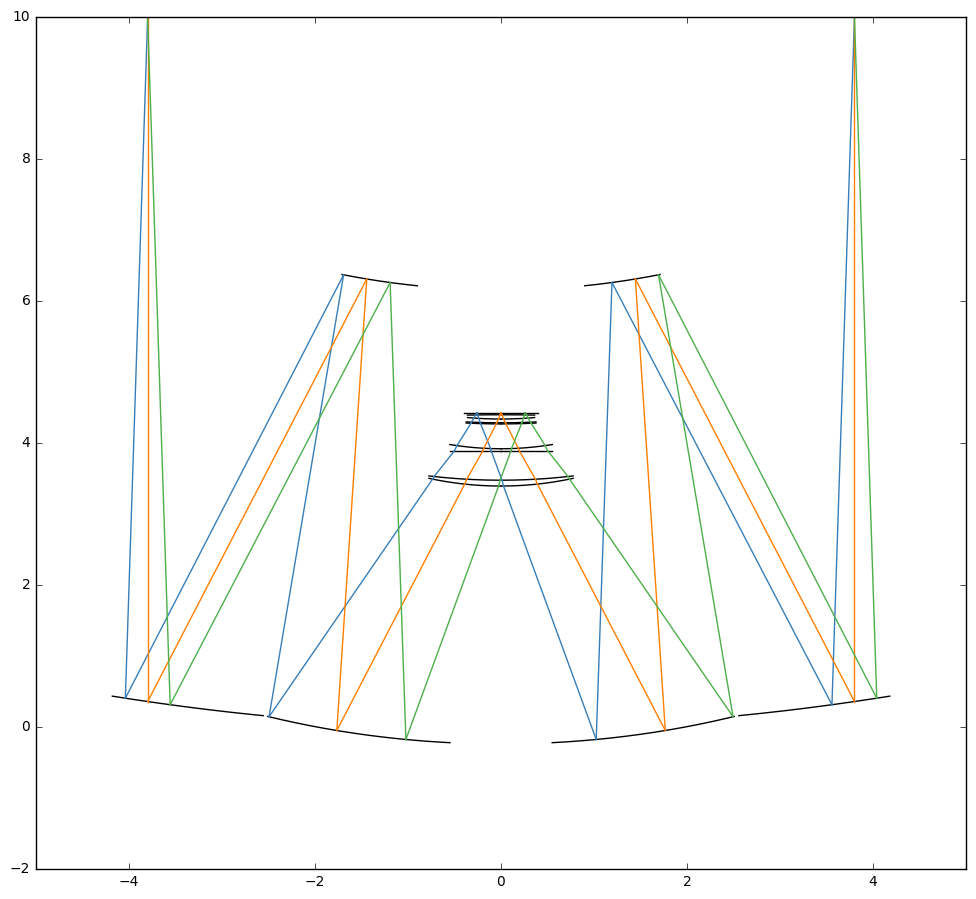

In [5]:
plt.figure(figsize=(12, 11))
for optic in telescope:
    x = np.linspace(-optic['outer'], -optic['inner'], 1000, endpoint=True)
    plt.plot(x, [optic['surface'](x_,0) for x_ in x], c='k')
    x = np.linspace(optic['inner'], optic['outer'], 1000, endpoint=True)
    plt.plot(x, [optic['surface'](x_,0) for x_ in x], c='k')

def trace(ray, telescope, color='r'):
    r = ray
    for optic in telescope:
        x0 = r.x0
        z0 = r.z0
        isec = optic['surface'].intersect(r)
        assert abs(isec.point.z - optic['surface'](isec.point.x, isec.point.y)) < 1e-10
        if optic['typ'] == 'mirror':
            r = isec.reflectedRay(r)
        elif optic['typ'] in ['lens', 'filter']:
            r = isec.refractedRay(r, optic['n0'], optic['n1'])
        x1 = isec.x0
        z1 = isec.z0
        plt.plot([x0, x1], [z0, z1], c=color)
    return isec.point

p0_left = jtrace.Vec3(-3.8, 0, 10)
p0_right = jtrace.Vec3(3.8, 0, 10)
v_left = jtrace.Vec3(-0.025, 0, -1).UnitVec3()/1.000277
v_mid = jtrace.Vec3(0, 0, -1).UnitVec3()/1.000277
v_right = jtrace.Vec3(0.025, 0, -1).UnitVec3()/1.000277

for v, c in zip([v_left, v_mid, v_right], ['#377eb8', '#ff7f00', '#4daf4a']):
    for p0 in [p0_left, p0_right]:
        ray = jtrace.Ray(p0, v, 0)
        print(trace(ray, telescope, color=c))

Vec3(-0.257942, 0, 4.42873)
Vec3(-0.25795, 0, 4.42873)
Vec3(1.37358e-06, 0, 4.42873)
Vec3(-1.37358e-06, 0, 4.42873)
Vec3(0.25795, 0, 4.42873)
Vec3(0.257942, 0, 4.42873)


(-0.5, 0.5)

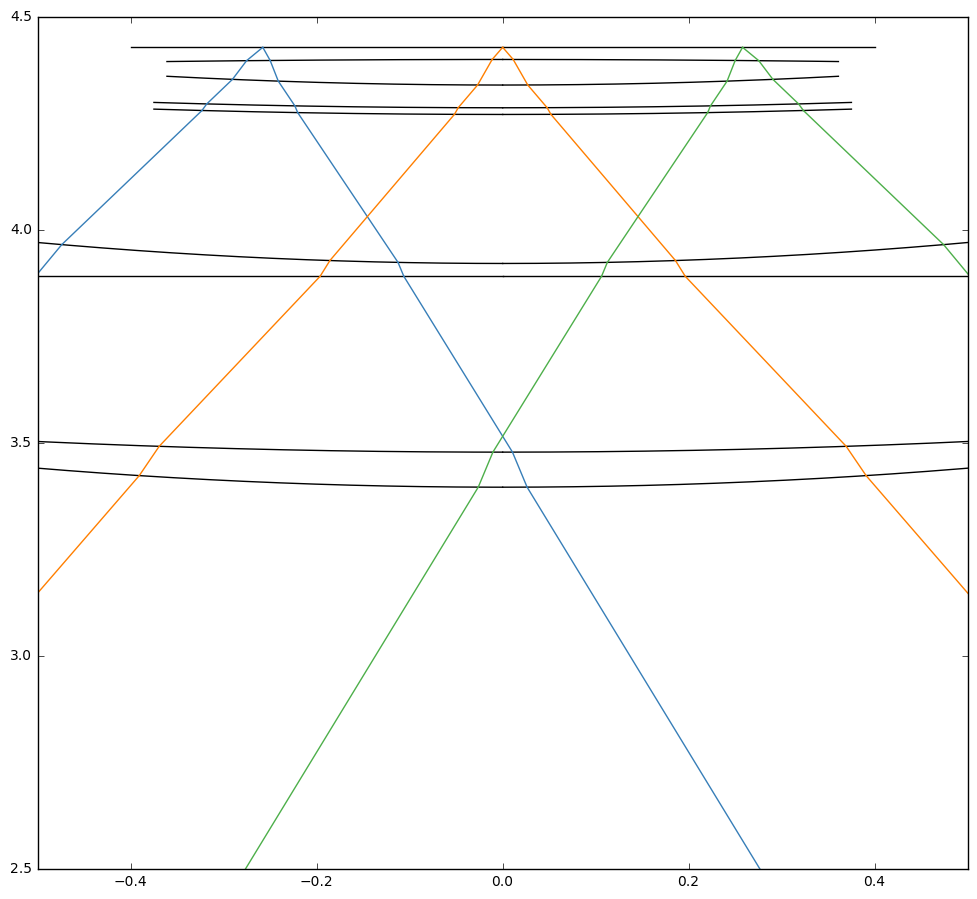

In [6]:
plt.figure(figsize=(12, 11))
for optic in telescope:
    x = np.linspace(-optic['outer'], -optic['inner'], 1000, endpoint=True)
    plt.plot(x, [optic['surface'](x_,0) for x_ in x], c='k')
    x = np.linspace(optic['inner'], optic['outer'], 1000, endpoint=True)
    plt.plot(x, [optic['surface'](x_,0) for x_ in x], c='k')

def trace(ray, telescope, color='r'):
    r = ray
    for optic in telescope:
        x0 = r.x0
        z0 = r.z0
        isec = optic['surface'].intersect(r)
        assert abs(isec.point.z - optic['surface'](isec.point.x, isec.point.y)) < 1e-10
        if optic['typ'] == 'mirror':
            r = isec.reflectedRay(r)
        elif optic['typ'] in ['lens', 'filter']:
            r = isec.refractedRay(r, optic['n0'], optic['n1'])
        x1 = isec.x0
        z1 = isec.z0
        plt.plot([x0, x1], [z0, z1], c=color)
    return isec.point

p0_left = jtrace.Vec3(-3.8, 0, 10)
p0_right = jtrace.Vec3(3.8, 0, 10)
v_left = jtrace.Vec3(-0.025, 0, -1).UnitVec3()/1.000277
v_mid = jtrace.Vec3(0, 0, -1).UnitVec3()/1.000277
v_right = jtrace.Vec3(0.025, 0, -1).UnitVec3()/1.000277

for v, c in zip([v_left, v_mid, v_right], ['#377eb8', '#ff7f00', '#4daf4a']):
    for p0 in [p0_left, p0_right]:
        ray = jtrace.Ray(p0, v, 0)
        print(trace(ray, telescope, color=c))
plt.ylim(2.5, 4.5)
plt.xlim(-0.5, 0.5)